Investigate the structure and operating principle of a neural network. Using a neural network, model a function of two variables.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generate data for a two-variable function
def generate_data(l_bound, h_bound, step=0.1):
    x_values = np.arange(l_bound, h_bound, step)
    y_values = np.sin(np.abs(x_values)) + np.cos(np.abs(x_values))
    z_values = x_values * np.sin(y_values)
    X = torch.tensor(np.stack((x_values, y_values), axis=1), dtype=torch.float32)
    y = torch.tensor(z_values, dtype=torch.float32).unsqueeze(1)
    return X, y, x_values, z_values

In [3]:
# Training and test sets
X_train, y_train, x_train_vals, z_train_vals = generate_data(0, 10)
X_test, y_test, x_test_vals, z_test_vals = generate_data(10, 15)

In [4]:
# Neural network with one hidden layer
class FeedforwardNN(nn.Module):
    def __init__(self, n_neurons):
        super(FeedforwardNN, self).__init__()
        self.hidden = nn.Linear(2, n_neurons)
        self.output = nn.Linear(n_neurons, 1)

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x

In [5]:
# Cascade neural network
class CascadeForwardNN(nn.Module):
    def __init__(self, config):
        super(CascadeForwardNN, self).__init__()
        self.hidden_layers = nn.ModuleList()

        # Adding internal layers with a direct connection to the inputs.
        input_size = 2
        for hidden_units in config:
            self.hidden_layers.append(nn.Linear(input_size, hidden_units))
            input_size += hidden_units  # Updated input size for each subsequent layer.

        # Output layer
        self.output_layer = nn.Linear(input_size, 1)

    def forward(self, x):
        inputs = [x]
        for hidden_layer in self.hidden_layers:
            out = torch.relu(hidden_layer(torch.cat(inputs, dim=1)))
            inputs.append(out)  # Cascade connection: inclusion of all previous layers
        x = torch.cat(inputs, dim=1)
        x = self.output_layer(x)
        return x

In [6]:
# Elman neural network
class ElmanBackpropNN(nn.Module):
    def __init__(self, hidden_sizes):
        super(ElmanBackpropNN, self).__init__()

        self.num_layers = len(hidden_sizes)

        self.rnn_layers = nn.ModuleList()

        input_size = 2  # Input size (for x and y)

        # Create RNN layers based on the hidden sizes
        if self.num_layers == 1:
            self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_sizes[0], batch_first=True)
        else:
            for hidden_size in hidden_sizes:
                self.rnn_layers.append(nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True))
                input_size = hidden_size
            self.rnn = None

        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], 1)

    def forward(self, x):
        x = x.unsqueeze(1)

        if self.rnn is not None:
            rnn_out, _ = self.rnn(x)
        else:
            for rnn in self.rnn_layers:
                x, _ = rnn(x)
            rnn_out = x

        out = self.output_layer(rnn_out[:, -1, :])
        return out

In [9]:
def train_evaluate_plot(model, n_neurons, epochs=1000):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    train_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test)
        mape = torch.mean(torch.abs((y_test - y_test_pred) / y_test)) * 100
        print(f"Number of neurons: {n_neurons}, MAPE: {mape.item():.2f}%")

        y_test_pred_np = y_test_pred.cpu().numpy().flatten()

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training error (MSE)")
    plt.xlabel("Epochs")
    plt.ylabel("Error (MSE)")
    plt.title(f"Dependence of the error on the number of epochs for {n_neurons} neurons.")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(x_test_vals, z_test_vals, 'o-', label='Real values of z')
    plt.plot(x_test_vals, y_test_pred_np, 'x-', label='Predicted values of z')
    plt.xlabel("x values")
    plt.ylabel("z values")
    plt.title(f"Comparison of actual and predicted z values, {n_neurons} neurons")
    plt.legend()
    plt.grid(True)
    plt.show()


Number of neurons: 10, MAPE: 66.62%


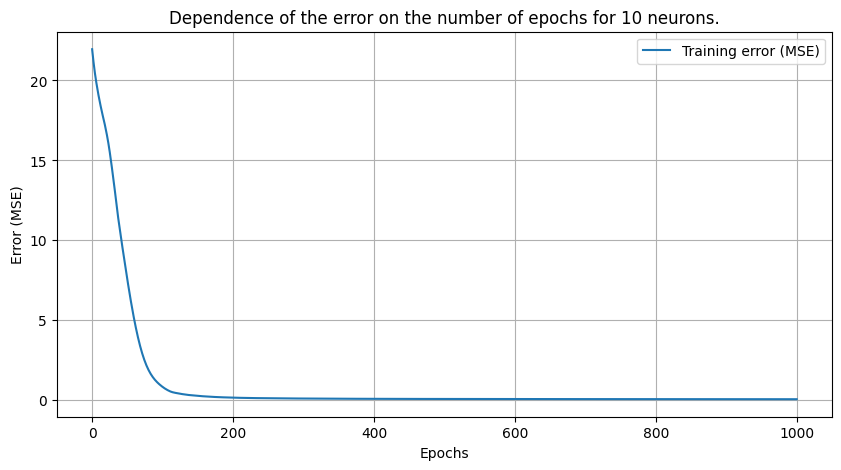

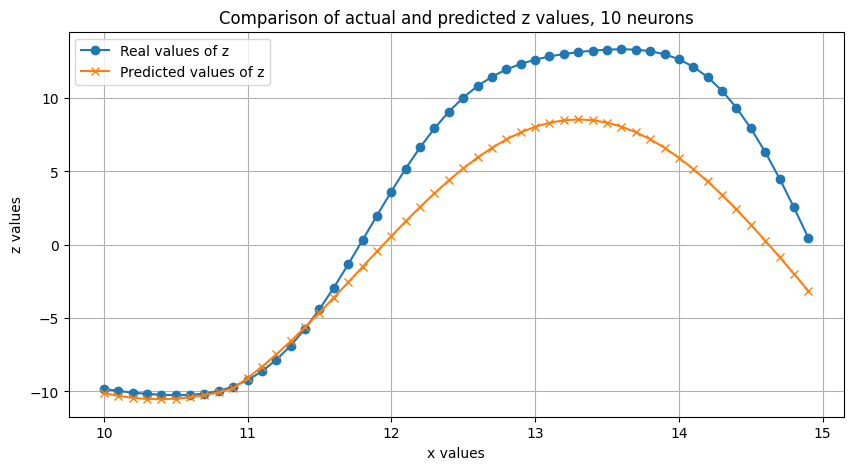

In [10]:
# Train and evaluate the model with one hidden layer
model = FeedforwardNN(10)
train_evaluate_plot(model, 10)

Number of neurons: 20, MAPE: 39.09%


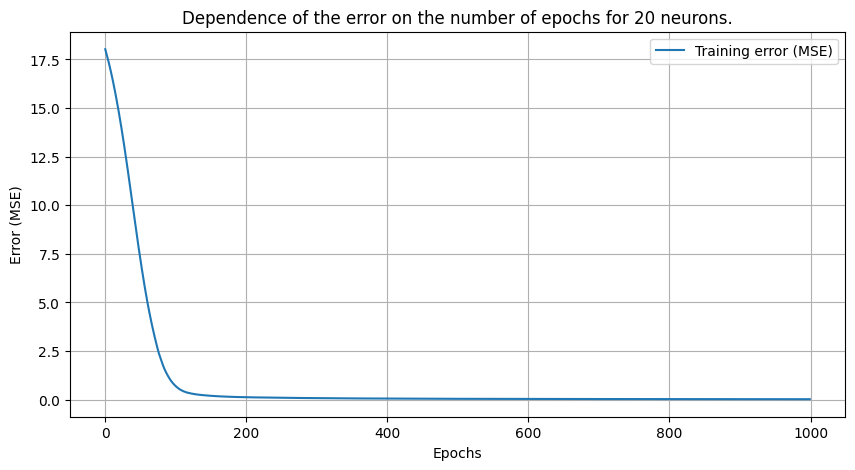

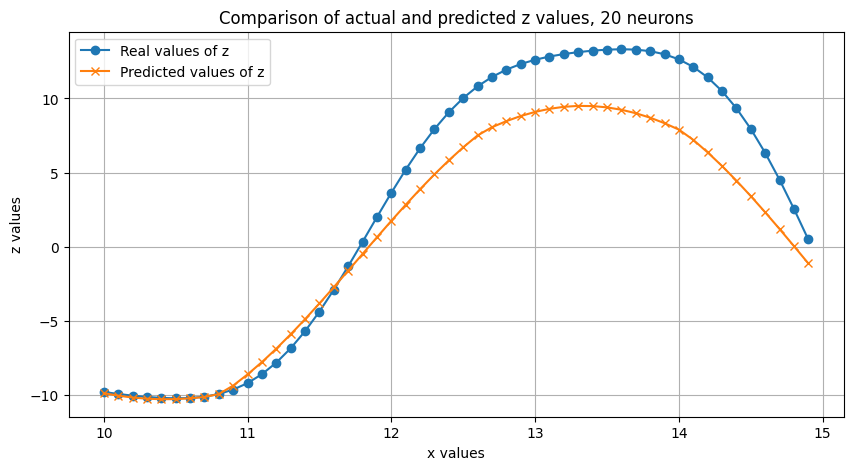

In [11]:
model_b = FeedforwardNN(10)
train_evaluate_plot(model_b, 20)

Number of neurons: 1 layer, 20 neurons, MAPE: 26.33%


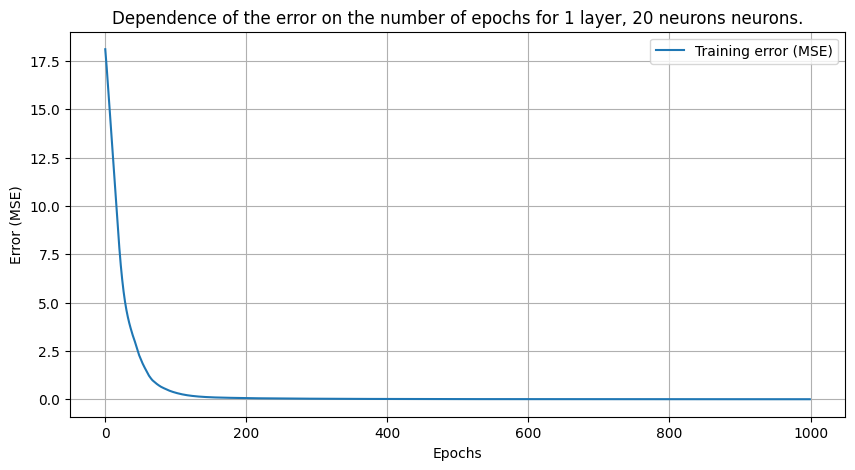

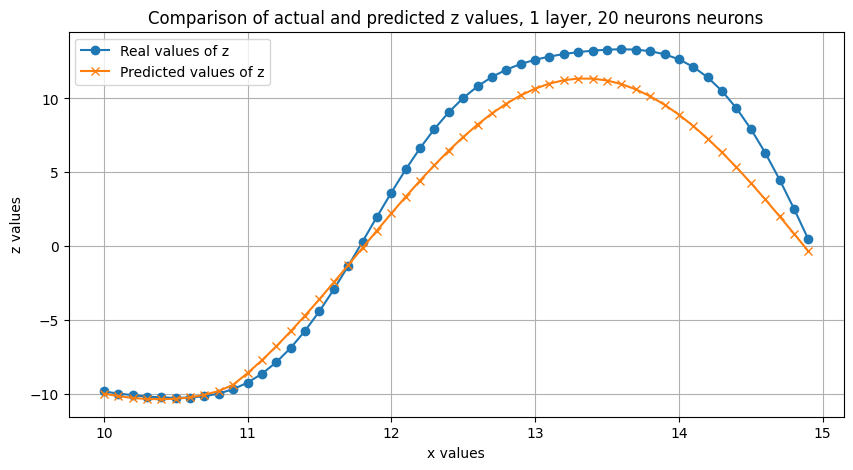

In [12]:
# A network with 1 hidden layer and 20 neurons
model_c = CascadeForwardNN([20])
train_evaluate_plot(model_c, n_neurons="1 layer, 20 neurons")


Number of neurons: 2 layers with 10 neurons each, MAPE: 57.09%


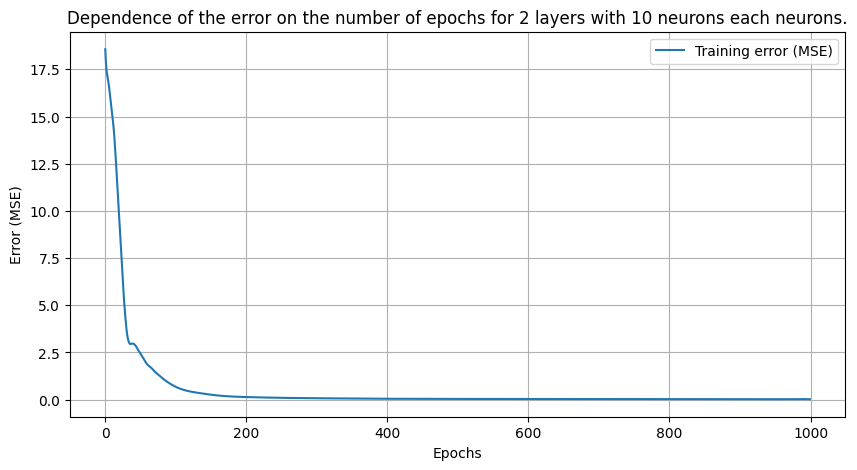

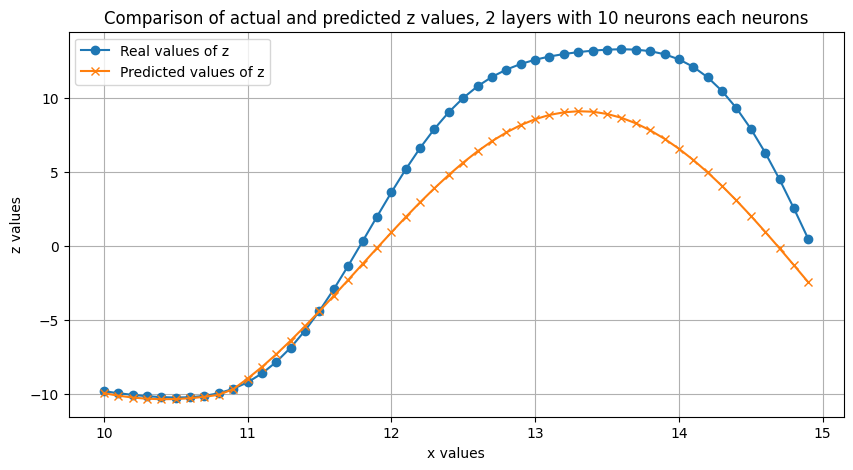

In [13]:
# A network with 2 hidden layers of 10 neurons each
model_d = CascadeForwardNN([10, 10])
train_evaluate_plot(model_d, n_neurons="2 layers with 10 neurons each")

Number of neurons: 15, MAPE: 74.88%


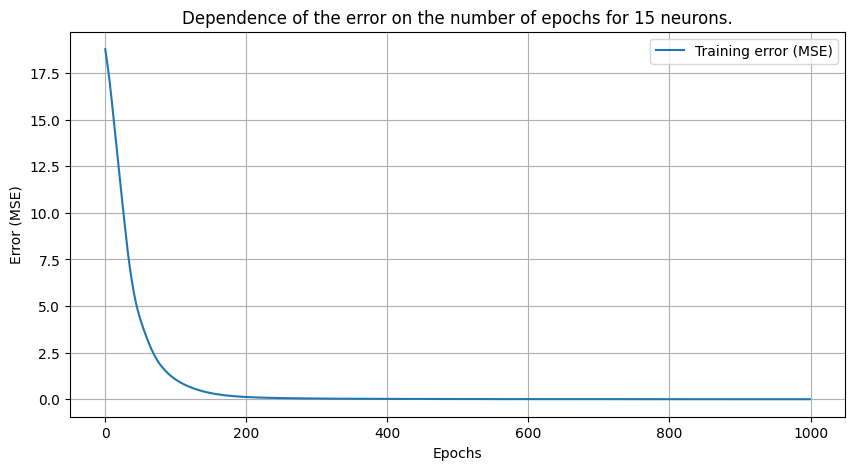

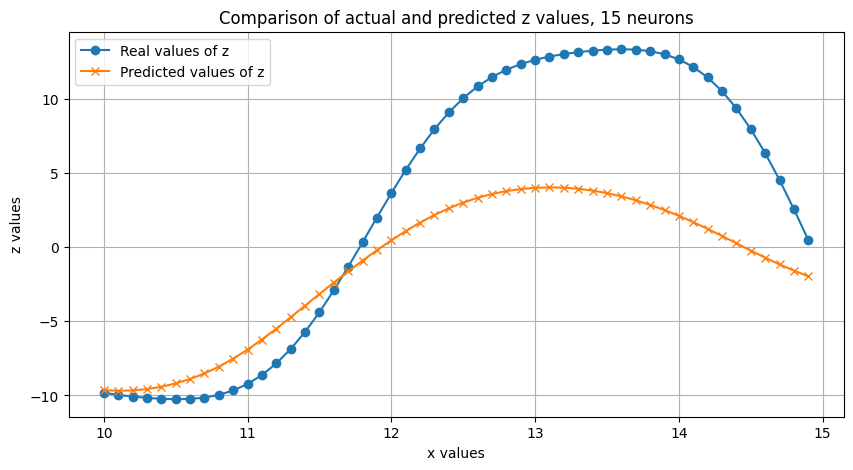

In [14]:
# 1 hidden layer with 15 neurons
model_e = ElmanBackpropNN(hidden_sizes=[15])
train_evaluate_plot(model_e, n_neurons=15)

Number of neurons: 3 layers with 5 neurons each, MAPE: 41.37%


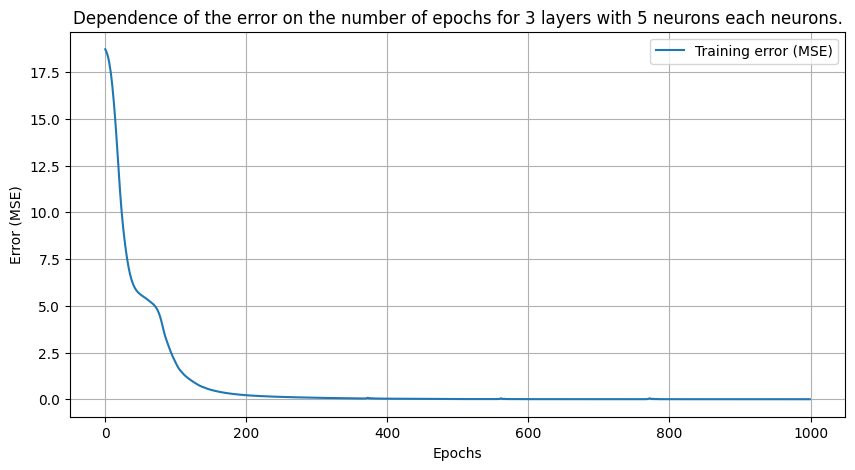

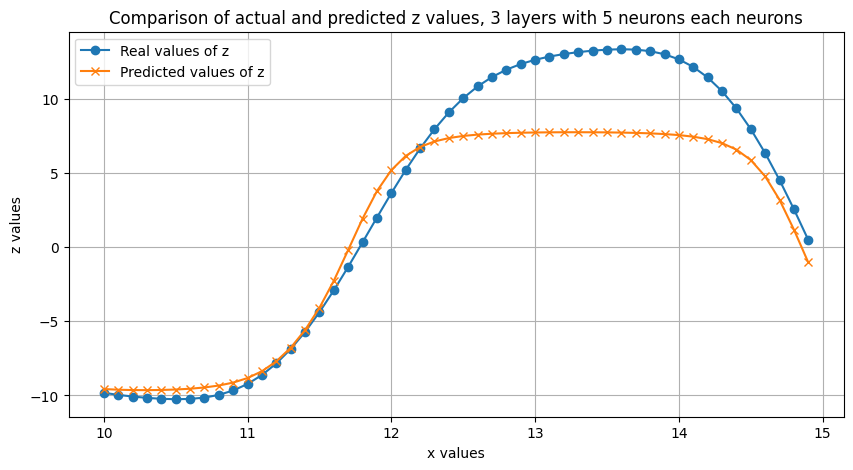

In [15]:
# 3 hidden layers with 5 neurons each
model_f = ElmanBackpropNN(hidden_sizes=[5, 5, 5])
train_evaluate_plot(model_f, n_neurons="3 layers with 5 neurons each")